This is not (yet) a tutorial. If you troubleshoot it, we can make it a tutorial for future people.

RMS-angle and distance distribution in angle space  
YJL Thurs Nov 19

In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals
import numpy as np
import pandas as pd
import os
import sys
import glob
import pathlib
import scipy as sp
from scipy import spatial

In [3]:
import matplotlib
from matplotlib import pylab
import matplotlib.patches as patches
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.pylab.rcParams.update(params)

In [8]:
# I have this as a python package, but I'm still editing it,
# so for now these are functions for you.

# NB: MDTraj uses radians by default, while MDAnalysis uses degrees, 
# but only sometimes.

#################################################################
# Loading things (Utilities)
def get_top_traj_path(dir_path, top_suffix, traj_suffix, sortfxn=None):
    """Get topology and trajectory path lists. This only works
    if you have 1 .psf or other topology file and several .dcd
    or other trajectory files in a folder."""
    # Topology path
    top_path = glob.glob(os.path.join(dir_path, f"*{top_suffix}"))[0]
    print(f"Topology path exists: {os.path.exists(top_path)}")
    if os.path.exists(top_path):
        print(f"Topology file is: {top_path.split('/')[-1]}")
    else:
        print(f"No topology found matching type *{top_suffix}")
    # Trajectory path
    traj_path_list = glob.glob(os.path.join(dir_path, f"*{traj_suffix}"))
    if sortfxn is None:
        traj_path_list.sort()
    else:
        traj_path_list = sortfxn(traj_path_list)
    print(f"{len(traj_path_list)} trajectories")
    return top_path, traj_path_list

def fname2partno(fname):
    """Go from name to part number. I always include _ptX in my fname."""
    parts = fname.split('_')
    found_part = False
    part_no = np.nan
    for part in parts:
        if part.startswith('pt'):
            try:
                part_no = int(part.strip('pt'))
                found_part = True
            except:
                print(f"Could not find integer part number for {fname}")
    if not found_part:
        print(f"Could not find part number designation 'pt' for {fname}")
    return part_no
    
def sort_fname_bypart(traj_path_list):
    pt_list = []
    for trajpath in traj_path_list:
        fname = pathlib.Path(trajpath).stem
        part_no = fname2partno(fname)
        pt_list.append(part_no)
    # sort part list
    pt_arr = np.array(pt_list)
    order = np.argsort(pt_arr)
    traj_order = [traj_path_list[i] for i in order]
    return traj_order




#################################################################
# Dihedral angles

def sel2phipsi(u, degree2radian=True):
    """MDAna selection u to phi and psi lists by segid
    NB: segid is sometimes chain in VMD"""
    segname_list = u.segments.segids.tolist()
    psi_list = []
    phi_list = []
    for seg in segname_list:
        # Chain information
        chain = u.select_atoms(f"protein and segid {seg}")
        # Phi and psi
        phi_sel, psi_sel, ind_phi, ind_psi = get_phipsi_sel(chain)
        phi_ang = get_dihe_ang(phi_sel, degree2radian)
        psi_ang = get_dihe_ang(psi_sel, degree2radian)
        # Append
        phi_list.append(phi_ang)
        psi_list.append(psi_ang)
    return phi_list, psi_list

def get_phipsi_sel(protein):
    # NB: to get a selection, e.g. protein = u.select_atoms("protein")
    phi_sel = [res.phi_selection() for res in protein.residues[:]]
    psi_sel = [res.psi_selection() for res in protein.residues[:]]
    # deal with None (edges)
    ind_phi, phi_sel = get_ind_none(phi_sel)
    ind_psi, psi_sel = get_ind_none(psi_sel)
    return phi_sel, psi_sel, ind_phi, ind_psi

def get_dihe_ang(phi_sel, degree2radian=True):
    """Get dihedral angles corresponding to selection (here phi)
    Input another dihedral selection (list) to get another angle."""
    phi_ang = mda.analysis.dihedrals.Dihedral(phi_sel).run().angles
    if degree2radian:
        phi_ang = phi_ang / 180 * np.pi
    return phi_ang

def get_ind_none(phi_sel):
    """Get indices in list that are none"""
    ind_none = []
    ind_not_none = []
    new_sel = []
    for i, sel in enumerate(phi_sel):
        if sel is None:
            ind_none.append(i)
        else:
            new_sel.append(sel)
            ind_not_none.append(i)
    return ind_not_none, new_sel


# ###################################################################
# From the circular analysis package
def get_angdiff(x, y):
    # NB: slightly slower but easier for me to read, possibly easier to dask-ify
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))
    return diff


def circ_dist(x, y):
    # one option for distance in circular space
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))
    dist = np.sqrt(np.sum(diff**2))
    return dist

def get_RMSA(traj, ref):
    """Root-mean-square angle
    Input:
        traj (Txm numpy array): dihedral angles from trajectory
        ref (length m numpy array): dihedral angles from reference structure
    Output:
        rmsa (length T numpy array): root-mean-square of dihedral angles
    """
    diff_dihe = get_angdiff(traj, ref)
    rmsa = np.sqrt(np.mean(diff_dihe**2, axis=1))
    return rmsa

In [9]:
project_path = os.path.abspath('..')

data_path = os.path.join(project_path, 'data', 'coronavirus_s1hinge')
run_path = os.path.join(data_path, 'traj_s1hinge_6vsb_a_Apr21')
ref_path = os.path.join(data_path, 'traj_s1hinge_6vsb_b_Apr21')
print(f"Checking: run_path exists: {os.path.exists(run_path)}")
print(f"Checking: ref_path exists: {os.path.exists(ref_path)}")
print("")

# Directory and file information
print("Loading data")
print("Run")
run_top_path, run_traj_path_list = get_top_traj_path(run_path, 'dry.psf', '.dcd')
print("")
print("Reference")
ref_top_path, ref_traj_path_list = get_top_traj_path(ref_path, 'dry.psf', 'dcd')


# Load data into mdana
u_run = mda.Universe(run_top_path, run_traj_path_list)
u_ref = mda.Universe(ref_top_path, ref_traj_path_list)

# Note: I don't load into memory to save memory, but you can if you have enough.
# It speeds up the calculation at the cost of memory
# u_run.transfer_to_memory()
# u_ref.transfer_to_memory()



Checking: run_path exists: True
Checking: ref_path exists: True

Loading data
Run
Topology path exists: True
Topology file is: s1hinge_6vsb_a_dry.psf
7 trajectories

Reference
Topology path exists: True
Topology file is: s1hinge_6vsb_b_dry.psf
9 trajectories


In [10]:
print(f"Run has {u_run.trajectory.n_frames} frames. \nRef has {u_ref.trajectory.n_frames} frames.")

Run has 50020 frames. 
Ref has 53084 frames.


In [11]:
# Phi and psi are lists of numpy arrays, one array per chain.
degree2radian = True
run_phi, run_psi = sel2phipsi(u_run, degree2radian)
ref_phi, ref_psi = sel2phipsi(u_ref, degree2radian)

In [12]:
# This example only has 1 chain, but the spike protein has
# 3 chains (DESRES, Martha's simulations) or 6 chains (Bowman).
# I'm leaving this setup in case you want to loop through the
# chains in the future. 
chain_id = 0
run_dihe_arr = np.column_stack((run_phi[chain_id], run_psi[chain_id]))
ref_dihe_arr = np.column_stack((ref_phi[chain_id], ref_psi[chain_id]))

print(f"Angles from {np.min(run_dihe_arr):.2f} to {np.max(run_dihe_arr):.2f}")
print(f"Run dihe data shape is {np.shape(run_dihe_arr)}")

Angles from -3.14 to 3.14
Run dihe data shape is (50020, 818)


# RMS-angle
NB: results depend on structure used as reference

In [13]:
# RMS-angle using the first frame of ref trajectory as the reference
rmsa_run_vs_run0 = get_RMSA(run_dihe_arr, run_dihe_arr[0, :])
rmsa_run_vs_ref0 = get_RMSA(run_dihe_arr, ref_dihe_arr[0, :])
rmsa_ref_vs_ref0 = get_RMSA(ref_dihe_arr, ref_dihe_arr[0, :])

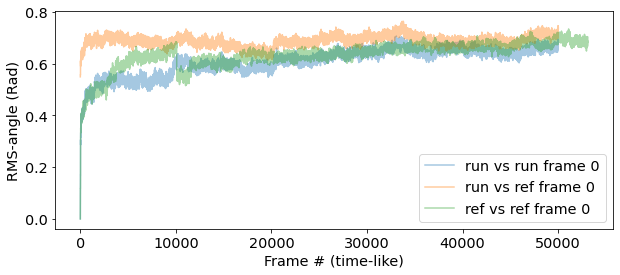

In [14]:
fig, ax = plt.subplots(figsize=[10, 4])
alpha = 0.4
ax.plot(rmsa_run_vs_run0, alpha=alpha, label='run vs run frame 0')
ax.plot(rmsa_run_vs_ref0, alpha=alpha, label='run vs ref frame 0')
ax.plot(rmsa_ref_vs_ref0, alpha=alpha, label='ref vs ref frame 0')
ax.set_ylabel('RMS-angle (Rad)')
ax.set_xlabel('Frame # (time-like)')
ax.legend()
plt.show()

# RMS distance distributions

In [15]:
# This is a callable a function for distance
circ_dist(run_dihe_arr[0, :], run_dihe_arr[5, :])

4.457204986732053

In [16]:
# T observations in n-dimensional space
downsample = 1000
dist_run_vs_run = sp.spatial.distance.cdist(run_dihe_arr[0::downsample, :], 
                                            run_dihe_arr[0::downsample, :], 
                                            metric=circ_dist)

In [17]:
dist_run_vs_ref = sp.spatial.distance.cdist(run_dihe_arr[0::downsample, :], 
                                            ref_dihe_arr[0::downsample, :], 
                                            metric=circ_dist)
dist_ref_vs_ref = sp.spatial.distance.cdist(ref_dihe_arr[0::downsample, :], 
                                            ref_dihe_arr[0::downsample, :], 
                                            metric=circ_dist)

In [18]:
def mat2tri(mat):
    ind_triu = np.triu_indices_from(mat, k=1)
    val = mat[ind_triu]
    return val

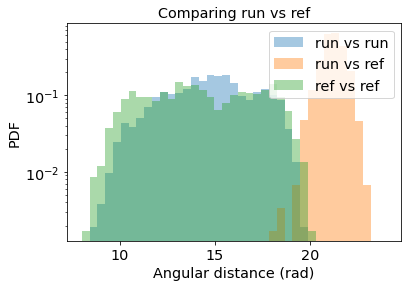

In [20]:
fig, ax = plt.subplots()
alpha = alpha
bins = np.linspace(8, 24, 40)
args = dict(bins=bins, alpha=alpha, density=True)
ax.hist(mat2tri(dist_run_vs_run), label='run vs run', **args)
ax.hist(mat2tri(dist_run_vs_ref), label='run vs ref', **args)
ax.hist(mat2tri(dist_ref_vs_ref), label='ref vs ref', **args)
plt.legend()
plt.xlabel('Angular distance (rad)')
plt.ylabel('PDF')
plt.title('Comparing run vs ref')
plt.yscale('log')
plt.show()